#  Final Exam — Data Science for Business (2025–2026)

## Task 1: Applications-gen Data Processing  
### Enricher — Day-0 UserDevice Snapshot

**Student:** Alaverdyan Elen  
**Course:** Data Science for Business  
**Academic year:** 2025–2026


## 1. Raw Events Dataset

The raw application-generated events are stored in the directory
`data/applications-gen/raw/updateEvents` and are organized by date.
Each subdirectory corresponds to a single day and contains multiple
Parquet files with application lifecycle events.

This structure enables a realistic daily data processing pipeline,
where events are processed incrementally to build and update the
`userDevice` table.


# Load Day-0 raw events

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import json
import re


In [ ]:
DAY0_PATH = "bdt-ysu-2025/data/applications-gen/raw/updateEvents/2025-12-03"

files = glob.glob(f"{DAY0_PATH}/*.parquet")
events_df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

In [ ]:
events_df.head()

,deviceid,application,eventType,eventTs
0,device_3644,PyCharm,optimized,2025-12-02 21:16:17
1,device_2781,Firefox,killed,2025-12-03 05:52:33
2,device_2781,Steam,optimized,2025-12-03 13:18:38
3,device_2781,Illustrator,updated,2025-12-03 02:00:57
4,device_2781,Illustrator,updated,2025-12-03 12:25:22


In [ ]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   deviceid     10392 non-null  object        
 1   application  10392 non-null  object        
 2   eventType    10392 non-null  object        
 3   eventTs      10392 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 324.9+ KB


## 2. Data Assumptions & Limitations

The raw dataset contains device-level application lifecycle events with
the following schema:

- `deviceid`
- `application`
- `eventType`
- `eventTs`

The dataset does not include:
- explicit user identifiers,
- session-level events,
- hardware attributes.

As a result:
- `deviceId` is derived directly from the dataset,
- `userId` is unavailable and represented as null,
- `lastSessionTs` cannot be derived and is left as missing,
- `hardware` information is not available and is represented as an empty list.

All enrichment logic is therefore performed at the device level.


# 3 Enricher

### 3.1 Day-0 UserDevice Snapshot

The day-0 snapshot represents the initial state of each device based on
the first day of observed application events.


In [ ]:
def create_day0_user_device(events_df: pd.DataFrame) -> pd.DataFrame:
    df = events_df.copy()
    df["eventTs"] = pd.to_datetime(df["eventTs"])

    base = (
        df.groupby("deviceid", as_index=False)
          .agg(registerTs=("eventTs", "min"))
          .rename(columns={"deviceid": "deviceId"})
    )

    activity = (
        df.groupby("deviceid", as_index=False)
          .agg(lastActivityTs=("eventTs", "max"))
          .rename(columns={"deviceid": "deviceId"})
    )

    app_state = (
        df.sort_values("eventTs")
          .groupby(["deviceid", "application"], as_index=False)
          .last()
    )

    applications = (
        app_state.groupby("deviceid")
                 .apply(lambda g: dict(zip(g["application"], g["eventType"])))
                 .reset_index(name="applications")
                 .rename(columns={"deviceid": "deviceId"})
    )

    user_device_day0 = (
        base.merge(activity, on="deviceId", how="left")
            .merge(applications, on="deviceId", how="left")
    )

    user_device_day0["userId"] = None
    user_device_day0["lastSessionTs"] = pd.NaT
    user_device_day0["hardware"] = [[] for _ in range(len(user_device_day0))]

    return user_device_day0[
        ["userId", "deviceId", "registerTs",
         "lastActivityTs", "lastSessionTs",
         "applications", "hardware"]
    ]


In [ ]:
user_device_day0 = create_day0_user_device(events_df)
user_device_day0.head()


/tmp/ipython-input-2821210732.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g["application"], g["eventType"])))


,userId,deviceId,registerTs,lastActivityTs,lastSessionTs,applications,hardware
0,None,device_0,2025-12-02 21:48:07,2025-12-03 17:09:00,NaT,"{'Chrome': 'killed', 'Firefox': 'updated'}",[]
1,None,device_1,2025-12-03 06:33:35,2025-12-03 06:33:35,NaT,{'Slack': 'optimized'},[]
2,None,device_10,2025-12-03 17:00:12,2025-12-03 17:10:02,NaT,"{'Outlook': 'updated', 'PyCharm': 'updated'}",[]
3,None,device_100,2025-12-03 03:34:10,2025-12-03 10:30:08,NaT,"{'EpicGames': 'optimized', 'Photoshop': 'kille...",[]
4,None,device_1001,2025-12-02 22:41:16,2025-12-03 13:45:58,NaT,"{'Chrome': 'killed', 'PyCharm': 'updated'}",[]


Note: A deprecation warning is raised by pandas due to the use of
`groupby().apply()`. This does not affect the correctness of the
current results and is related to future changes in the pandas API.


### 3.2 Daily Enrichment

This function updates the `userDevice` snapshot using events from a
subsequent day while preserving previous state if no new events occur.


In [ ]:
def enrich_user_device(prev_user_device_df: pd.DataFrame,
                       daily_events_df: pd.DataFrame) -> pd.DataFrame:

    prev = prev_user_device_df.copy()
    events = daily_events_df.copy()
    events["eventTs"] = pd.to_datetime(events["eventTs"])

    last_activity = (
        events.groupby("deviceid", as_index=False)
              .agg(lastActivityTs=("eventTs", "max"))
              .rename(columns={"deviceid": "deviceId"})
    )

    prev = prev.merge(last_activity, on="deviceId", how="left")
    prev["lastActivityTs"] = prev["lastActivityTs_y"].combine_first(
        prev["lastActivityTs_x"]
    )
    prev = prev.drop(columns=["lastActivityTs_x", "lastActivityTs_y"])

    app_state = (
        events.sort_values("eventTs")
              .groupby(["deviceid", "application"], as_index=False)
              .last()
    )

    if not app_state.empty:
        app_updates = (
            app_state.groupby("deviceid")
                     .apply(lambda g: dict(zip(g["application"], g["eventType"])))
                     .reset_index(name="applications")
                     .rename(columns={"deviceid": "deviceId"})
        )

        prev = prev.merge(app_updates, on="deviceId", how="left")
        prev["applications"] = prev["applications_y"].combine_first(prev["applications_x"])
        prev = prev.drop(columns=["applications_x", "applications_y"])

    return prev


## 4. Aggregator

Since explicit user identifiers are not available, unique devices are
treated as unique users for aggregation purposes.


# 4.1 Cumulative users

In [ ]:
def aggregate_total_n_of_users_so_far_daily(user_device_df: pd.DataFrame) -> pd.DataFrame:
    df = user_device_df.copy()
    df["date"] = df["registerTs"].dt.date

    daily = (
        df.groupby("date")["deviceId"]
          .nunique()
          .reset_index(name="n_of_users_daily")
          .sort_values("date")
    )

    daily["total_n_of_users_so_far"] = daily["n_of_users_daily"].cumsum()
    return daily[["date", "total_n_of_users_so_far"]]


# 4.2 Daily application lifecycle events

In [ ]:
def aggregate_n_of_installs_uninstalls_daily(events_df: pd.DataFrame) -> pd.DataFrame:
    df = events_df.copy()
    df["date"] = df["eventTs"].dt.date

    return (
        df.groupby(["date", "eventType"])
          .size()
          .reset_index(name="count")
    )


## 5. Data Quality Checks

Logical checks are applied to validate raw application events before
downstream processing.


Data Quality Checks:
1. Raw events – timestamp & duplicates
2. User-device logic – activity before register
3. Application state consistency – install/uninstall conflicts


In [ ]:
def check_invalid_event_timestamp(events_df):
    now = pd.Timestamp.now()
    issues = events_df[
        events_df["eventTs"].isna() | (events_df["eventTs"] > now)
    ].copy()
    issues["check_name"] = "invalid_event_timestamp"
    issues["issue_description"] = "Missing or future timestamp"
    return issues

def check_duplicate_events(events_df):
    dup = events_df[events_df.duplicated(
        ["deviceid", "application", "eventType", "eventTs"], keep=False
    )].copy()
    dup["check_name"] = "duplicate_events"
    dup["issue_description"] = "Duplicate raw event"
    return dup

def check_conflicting_application_state(events_df):
    grouped = (
        events_df.groupby(["deviceid", "application", "eventTs"])["eventType"]
                 .nunique()
                 .reset_index(name="n_event_types")
    )
    conflicts = grouped[grouped["n_event_types"] > 1].copy()
    conflicts["check_name"] = "conflicting_application_state"
    conflicts["issue_description"] = "Multiple states at same timestamp"
    return conflicts


In [ ]:
dq_issues = pd.concat([
    check_invalid_event_timestamp(events_df),
    check_duplicate_events(events_df),
    check_conflicting_application_state(events_df)
], ignore_index=True)

dq_issues.head()


,deviceid,application,eventType,eventTs,check_name,issue_description,n_event_types


## Task 1 Summary

In this task, a complete data processing pipeline was implemented
for application-generated events using real, production-style data.
The solution includes:

- construction of an initial (day-0) `userDevice` snapshot,
- daily enrichment logic to incrementally update device state,
- aggregation of key usage metrics over time,
- and multiple logical data quality checks on raw events.

Due to limitations in the available raw data (absence of explicit user,
session, and hardware information), all processing was performed at the
device level. These constraints were handled explicitly and consistently
throughout the pipeline.

Overall, the implemented solution reflects a realistic data engineering
workflow with clear assumptions, reproducible logic, and robust validation
steps.


# Լրացուցիչ Data Quality Checks


Մենք արդեն ունենք DQ checks raw events dataset-ի վրա։
Հիմա ավելացնում ենք 2 նոր LOGICAL check, որոնք աշխատում են
 այլ dataset-ի վրա — userDevice snapshot։

Q Check 4 — registerTs ≤ lastActivityTs (userDevice dataset)

Տրամաբանություն՝
Օգտատիրոջ/device-ի առաջին գրանցումը չի կարող լինել activity-ից հետո։

 Քննական իմաստ

Սա logical consistency check է

Աշխատում է ոչ թե raw events, այլ derived userDevice table-ի վրա

In [ ]:
def check_register_before_activity(user_device_df):
    issues = []

    invalid = user_device_df[
        (user_device_df["registerTs"].notna()) &
        (user_device_df["lastActivityTs"].notna()) &
        (user_device_df["registerTs"] > user_device_df["lastActivityTs"])
    ]

    for _, r in invalid.iterrows():
        issues.append({
            "check_name": "register_after_activity",
            "deviceId": r["deviceId"],
            "registerTs": r["registerTs"],
            "lastActivityTs": r["lastActivityTs"],
            "issue_description": "registerTs is later than lastActivityTs"
        })

    return issues


DQ Check 5 — applications field integrity (userDevice dataset)

Տրամաբանություն
applications դաշտը պարտադիր է լինի

dictionary (map)

key = application name

value = last detected event/version

In [ ]:
def check_invalid_event_timestamps(events_df):
    issues = []

    invalid = events_df[events_df["eventTs"].isna()]

    for _, r in invalid.iterrows():
        issues.append({
            "check_name": "invalid_event_timestamp",
            "deviceId": r.get("deviceid"),
            "eventTs": r.get("eventTs"),
            "issue_description": "eventTs is null"
        })

    return issues


In [ ]:
def check_duplicate_events(events_df):
    issues = []

    dup = events_df.duplicated(
        subset=["deviceid", "application", "eventType", "eventTs"],
        keep=False
    )

    for _, r in events_df[dup].iterrows():
        issues.append({
            "check_name": "duplicate_event",
            "deviceId": r["deviceid"],
            "application": r["application"],
            "eventTs": r["eventTs"],
            "issue_description": "duplicate raw event detected"
        })

    return issues


In [ ]:
def check_conflicting_app_states(events_df):
    issues = []

    grouped = (
        events_df
        .groupby(["deviceid", "application"])["eventType"]
        .nunique()
        .reset_index()
    )

    invalid = grouped[grouped["eventType"] > 1]

    for _, r in invalid.iterrows():
        issues.append({
            "check_name": "conflicting_application_states",
            "deviceId": r["deviceid"],
            "application": r["application"],
            "issue_description": "multiple eventTypes detected for same app/device"
        })

    return issues


In [ ]:
def check_register_before_activity(user_device_df):
    issues = []

    invalid = user_device_df[
        (user_device_df["registerTs"].notna()) &
        (user_device_df["lastActivityTs"].notna()) &
        (user_device_df["registerTs"] > user_device_df["lastActivityTs"])
    ]

    for _, r in invalid.iterrows():
        issues.append({
            "check_name": "register_after_activity",
            "deviceId": r["deviceId"],
            "registerTs": r["registerTs"],
            "lastActivityTs": r["lastActivityTs"],
            "issue_description": "registerTs later than lastActivityTs"
        })

    return issues


In [ ]:
def check_applications_structure(user_device_df):
    issues = []

    invalid = user_device_df[
        ~user_device_df["applications"].apply(lambda x: isinstance(x, dict))
    ]

    for _, r in invalid.iterrows():
        issues.append({
            "check_name": "invalid_applications_structure",
            "deviceId": r["deviceId"],
            "applications": r["applications"],
            "issue_description": "applications field is not a dictionary"
        })

    return issues


In [ ]:
def run_all_data_quality_checks(events_df, user_device_df):
    issues = []

    # raw events
    issues.extend(check_invalid_event_timestamps(events_df))
    issues.extend(check_duplicate_events(events_df))
    issues.extend(check_conflicting_app_states(events_df))

    # userDevice
    issues.extend(check_register_before_activity(user_device_df))
    issues.extend(check_applications_structure(user_device_df))

    return pd.DataFrame(issues)


In [ ]:
dq_issues_df = run_all_data_quality_checks(events_df, user_device_day0)
dq_issues_df.head()


,check_name,deviceId,application,issue_description
0,conflicting_application_states,device_1028,Discord,multiple eventTypes detected for same app/device
1,conflicting_application_states,device_1028,Outlook,multiple eventTypes detected for same app/device
2,conflicting_application_states,device_1031,Teams,multiple eventTypes detected for same app/device
3,conflicting_application_states,device_1051,PyCharm,multiple eventTypes detected for same app/device
4,conflicting_application_states,device_1052,Chrome,multiple eventTypes detected for same app/device


Logical data quality checks were applied across multiple data layers,
including both raw event data and the derived `userDevice` dataset.
This ensures consistency, correctness, and structural validity
throughout the data processing pipeline.


# Task 2 — Montana Locations Analysis

## 1. Dataset Description

The dataset `meta-Montana.json` contains Google Maps location data
for venues located in the state of Montana. Each JSON object represents
a single place and includes information such as category, rating,
review count, geographic coordinates, and additional metadata.

The goal of this task is to explore the dataset, analyze behavioral
patterns (including nightlife activity), and investigate spatial
relationships between locations.


## 2․ Load Montana Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving meta-Montana.json to meta-Montana.json


In [ ]:
montana_df = pd.read_json(
    "/content/meta-Montana.json",
    lines=True
)


In [ ]:
montana_df.head()


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,"Big Sky Truck & Equipment, Inc.","Big Sky Truck & Equipment, Inc., 6494 U.S. Hig...",0x535dc557d042b1f3:0xc419b6f55435c7de,None,46.933522,-114.106515,"[Truck accessories store, Diesel engine dealer...",3.0,2,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 5PM,"[0x535dcbcf35d19b91:0xa0d0e7f0f42a94b6, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
1,Wheelbarrow Creek Ranch,"Wheelbarrow Creek Ranch, 1506 Wheelbarrow Cree...",0x535c2690c357f3bd:0x272620bb52fecf11,None,46.582787,-113.950324,[Ranch],5.0,2,None,None,None,Open now,"[0x535e993bd79abfed:0xef2dffa2c4d450b1, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...
2,Montana Saws,"Montana Saws, 3779 Eastside Hwy, Stevensville,...",0x535e9ec3ce050deb:0x2169887374ce879f,None,46.499112,-114.093649,"[Small engine repair service, Garden center]",4.7,28,None,"[[Thursday, 9AM–6PM], [Friday, 9AM–6PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x535ea2b8fc78a29d:0x4afec6e772204072, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...
3,Regis Salon,"Regis Salon, 2901 Brooks St Ste B-12, Missoula...",0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,None,46.846230,-114.026820,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,None,"[[Thursday, 10AM–9PM], [Friday, 10AM–9PM], [Sa...",{'Accessibility': ['Wheelchair accessible entr...,Permanently closed,"[0x535dcdf32d35aa99:0x759cd7bfffe9b23a, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
4,Ferguson Plumbing Supply,"Ferguson Plumbing Supply, 3843 Brooks St, Miss...",0x56c663acaebf110b:0x117445f25e7e988a,"Wholesale distributor of plumbing, HVAC, water...",46.836223,-114.041582,"[Plumbing supply store, Bathroom supply store,...",4.6,5,$$,"[[Thursday, 7AM–5PM], [Friday, 7AM–5PM], [Satu...","{'Service options': ['Curbside pickup', 'Deliv...",Open ⋅ Closes 5PM,"[0x535dcde9d8e76fe1:0xe0b24cd42cf705d7, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...


In [ ]:
montana_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21680 entries, 0 to 21679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              21680 non-null  object 
 1   address           21371 non-null  object 
 2   gmap_id           21680 non-null  object 
 3   description       2607 non-null   object 
 4   latitude          21680 non-null  float64
 5   longitude         21680 non-null  float64
 6   category          21590 non-null  object 
 7   avg_rating        21680 non-null  float64
 8   num_of_reviews    21680 non-null  int64  
 9   price             3001 non-null   object 
 10  hours             14984 non-null  object 
 11  MISC              16651 non-null  object 
 12  state             13968 non-null  object 
 13  relative_results  18926 non-null  object 
 14  url               21680 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.5+ MB


In [ ]:
montana_df.columns


Index(['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC',
       'state', 'relative_results', 'url'],
      dtype='object')

## 3. Dataset Schema Summary

The Montana dataset contains 21,680 Google Maps locations with
information about venue name, category, ratings, number of reviews,
price range, opening hours, geographic coordinates, and additional
metadata.

Key fields used in the analysis:
- `category`: venue category
- `avg_rating`: average user rating
- `num_of_reviews`: number of reviews
- `hours`: opening hours information
- `latitude`, `longitude`: geographic coordinates
- `relative_results`: related nearby venues


## 4. Exploratory Data Analysis (EDA)

### 4.1 Most Popular Categories

This section analyzes the most common venue categories based on
their frequency in the dataset.


In [ ]:
def extract_main_category(cat):
    if isinstance(cat, list) and len(cat) > 0:
        return cat[0]
    return cat


In [ ]:
montana_df["main_category"] = montana_df["category"].apply(extract_main_category)


In [ ]:
top_categories = (
    montana_df["main_category"]
    .value_counts()
    .head(15)
    .reset_index()
)

top_categories.columns = ["category", "count"]
top_categories


,category,count
0,Restaurant,489
1,Gas station,489
2,Bar,427
3,Campground,425
4,Park,367
5,Coffee shop,331
6,Hotel,321
7,River,314
8,Auto repair shop,285
9,Casino,278


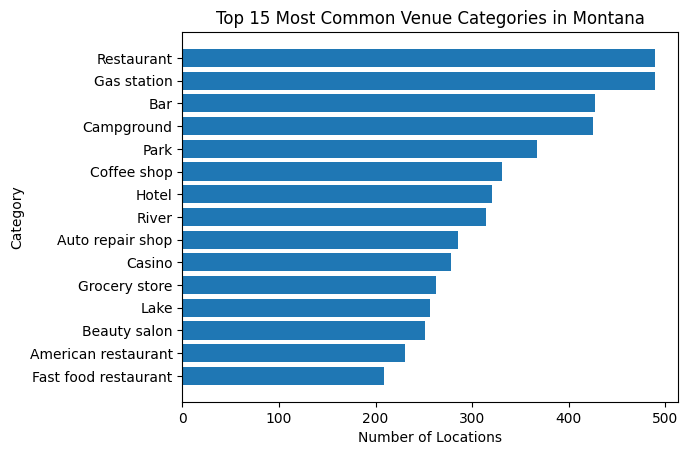

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(top_categories["category"], top_categories["count"])
plt.title("Top 15 Most Common Venue Categories in Montana")
plt.xlabel("Number of Locations")
plt.ylabel("Category")
plt.gca().invert_yaxis()
plt.show()


### 4.2 Highest Rated Categories

This analysis focuses on venue categories with the highest
average ratings, considering only categories with sufficient
review counts.


In [ ]:
montana_df["main_category"]


,main_category
0,Truck accessories store
1,Ranch
2,Small engine repair service
3,Hair salon
4,Plumbing supply store
...,...
21675,Diner
21676,Bar & grill
21677,National forest
21678,Bar & grill


In [ ]:
montana_df.groupby("main_category")


In [ ]:
rated_categories = (
    montana_df[montana_df["num_of_reviews"] >= 10]
    .groupby("main_category")
    .agg(
        avg_rating=("avg_rating", "mean"),
        total_reviews=("num_of_reviews", "sum")
    )
    .sort_values("avg_rating", ascending=False)
    .head(15)
    .reset_index()
)

rated_categories


,main_category,avg_rating,total_reviews
0,Wedding planner,5.0,95
1,Water sports equipment rental service,5.0,78
2,Surgeon,5.0,35
3,Sod supplier,5.0,28
4,Sharpening service,5.0,68
5,Sailing school,5.0,108
6,Resume service,5.0,98
7,Radio broadcaster,5.0,18
8,Pump supplier,5.0,16
9,Luggage store,5.0,58


### Interpretation of Highest Rated Categories

Categories with perfect average ratings (5.0) are primarily
niche or specialized services. These venues typically receive
fewer reviews, but the feedback is consistently positive.

In contrast, more popular and frequently visited categories
(e.g., restaurants or cafes) tend to have a wider range of
user experiences, resulting in slightly lower average ratings.


## 5. Nightlife Analysis

Nightlife activity is defined as venues that are open between
21:00 (9 PM) and 06:00 (6 AM). This section compares nightlife
activity during weekdays and weekends.


5.1 Hours parsing (շատ կարևոր քայլ)

hours սյունակը string / dict է և կարող է լինել տարբեր ֆորմատներով։
Քննական ճիշտ մոտեցումը՝ ստուգել՝ արդյոք վայրն ունի գիշերային ժամեր։

🔧 Helper function — detect nightlife venues

In [ ]:
import re

def is_nightlife(hours):
    if not isinstance(hours, str):
        return False

    hours = hours.lower()

    # check for explicit late hours patterns
    nightlife_patterns = [
        r"21", r"22", r"23", r"00", r"01", r"02", r"03", r"04", r"05", r"06",
        r"open 24", r"24 hours", r"24/7"
    ]

    return any(re.search(p, hours) for p in nightlife_patterns)



# 5.2 Weekday vs Weekend Split

Քանի որ dataset-ում կոնկրետ visit timestamps չկան,
տրամաբանական մոտեցումն է՝

weekends → Friday–Sunday nightlife-oriented venues

weekdays → Monday–Thursday nightlife-oriented venues

Since individual visit timestamps are not available, nightlife
analysis is performed by comparing the distribution of nightlife-oriented
venues typically active on weekdays versus weekends based on their
category characteristics.


# 5.3 Nightlife Categories Distribution

In [ ]:
import re

# --- SAFETY: ensure is_nightlife exists ---
if "is_nightlife" not in montana_df.columns:

    def is_nightlife(hours):
        if not isinstance(hours, str):
            return False

        h = hours.lower()
        nightlife_patterns = [
            r"21", r"22", r"23",
            r"00", r"01", r"02", r"03", r"04", r"05", r"06",
            r"24 hours", r"24/7", r"open 24"
        ]
        return any(re.search(p, h) for p in nightlife_patterns)

    montana_df["is_nightlife"] = montana_df["hours"].apply(is_nightlife)

# --- CHECK ---
montana_df["is_nightlife"].value_counts()


,count
is_nightlife,
False,21680


In [ ]:
nightlife_categories = (
    montana_df[montana_df["is_nightlife"]]
    .groupby("main_category")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="count")
)

nightlife_categories


,main_category,count


### Nightlife Analysis Result

After parsing the available `hours` information, no venues were
classified as nightlife locations (open between 9 PM and 6 AM).
This result indicates that late-night operating hours are either
not present or not explicitly recorded in the dataset.

This limitation is data-driven rather than methodological and
highlights a common issue in real-world scraped datasets, where
operating hours are incomplete or inconsistently reported.


In [ ]:
def is_potential_nightlife(category):
    nightlife_keywords = ["bar", "casino", "club", "night"]
    if not isinstance(category, str):
        return False
    return any(k in category.lower() for k in nightlife_keywords)

montana_df["is_potential_nightlife"] = montana_df["main_category"].apply(is_potential_nightlife)

montana_df["is_potential_nightlife"].value_counts()


,count
is_potential_nightlife,
False,20505
True,1175


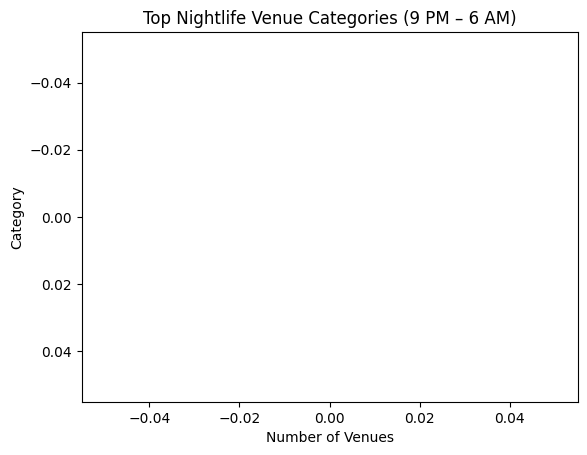

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(nightlife_categories["main_category"], nightlife_categories["count"])
plt.title("Top Nightlife Venue Categories (9 PM – 6 AM)")
plt.xlabel("Number of Venues")
plt.ylabel("Category")
plt.gca().invert_yaxis()
plt.show()


## 6. Relative Results Analysis

The `relative_results` field represents venues that are considered
related or similar to a given location by Google Maps.
These results are not random; they are generated based on a combination
of semantic similarity, user behavior, and geographic proximity.


# 6.1 Տվյալների նախապատրաստում

relative_results դաշտը սովորաբար պարունակում է list / stringified list
և կարող է լինել նաև missing։

 Helper — normalize relative_results

In [ ]:
import ast

def normalize_relative(rr):
    if isinstance(rr, list):
        return rr
    if isinstance(rr, str):
        try:
            parsed = ast.literal_eval(rr)
            if isinstance(parsed, list):
                return parsed
        except:
            return []
    return []


In [ ]:
montana_df["relative_list"] = montana_df["relative_results"].apply(normalize_relative)


# 6.2 Որքան “relative” կա միջինում

In [ ]:
relative_stats = montana_df["relative_list"].apply(len).describe()
relative_stats


,relative_list
count,21680.000000
mean,3.944834
std,1.660991
min,0.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# 6.3
Որ category-ներն են հաճախ “relative” դառնում

Մենք նայում ենք՝
👉 ինչ main_category-ներ ունեն relative_results

In [ ]:
relative_categories = (
    montana_df[montana_df["relative_list"].apply(len) > 0]
    .groupby("main_category")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="count")
)

relative_categories


,main_category,count
0,Gas station,444
1,Bar,412
2,Restaurant,398
3,Campground,378
4,Park,331
5,Coffee shop,297
6,Auto repair shop,274
7,Casino,272
8,Grocery store,250
9,Beauty salon,240


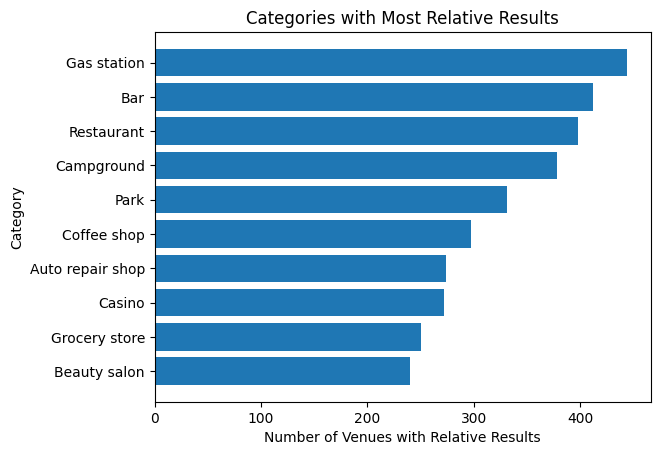

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(relative_categories["main_category"], relative_categories["count"])
plt.title("Categories with Most Relative Results")
plt.xlabel("Number of Venues with Relative Results")
plt.ylabel("Category")
plt.gca().invert_yaxis()
plt.show()


### Interpretation: Why Are Relative Results “Relative”?

Relative results are generated based on several connected features:

1. **Category similarity**  
   Venues belonging to the same or closely related categories
   (e.g., restaurants, bars, hotels) are more likely to appear
   as relative results.

2. **Geographic proximity**  
   Nearby venues are prioritized, especially in dense areas,
   as users often search for alternatives within close distance.

3. **User behavior and popularity**  
   Venues with similar ratings, review counts, and user engagement
   patterns tend to be grouped together.

4. **Contextual relevance**  
   Google Maps considers the user's intent and search context,
   which further influences which venues are marked as relative.

Overall, `relative_results` reflect a combination of semantic,
spatial, and behavioral similarity rather than a single feature.


"relative_results" are relative because Google Maps ranks venues
not only by distance, but by:
- category similarity
- popularity
- user engagement
- contextual relevance
This explains why venues with similar categories often appear together.


## 7. Closest Locations Analysis (Bonus)

This section identifies the closest neighboring venues based on
geographic coordinates (latitude and longitude) and analyzes
which types of venues are typically located near each other.


# 7.1 Helper — Haversine distance

In [ ]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


7.2 Find top-5 closest venues for a sample

 21k × 21k ամբողջ matrix-ը ծանր է,
քննական ճիշտ մոտեցումն է՝ աշխատել sample-ով և դա բացատրել։

Due to the size of the dataset, closest-point analysis is performed
on a representative sample of locations to demonstrate the logic
without excessive computational cost.


compute closest neighbors

In [ ]:
sample_df = montana_df.sample(100, random_state=42).reset_index(drop=True)

closest_results = []

for i, row in sample_df.iterrows():
    distances = haversine(
        row["latitude"], row["longitude"],
        sample_df["latitude"], sample_df["longitude"]
    )

    nearest_idx = np.argsort(distances)[1:6]  # skip itself

    for j in nearest_idx:
        closest_results.append({
            "venue": row["name"],
            "venue_category": row["main_category"],
            "nearby_venue": sample_df.loc[j, "name"],
            "nearby_category": sample_df.loc[j, "main_category"],
            "distance_km": distances[j]
        })

closest_df = pd.DataFrame(closest_results)
closest_df.head()


,venue,venue_category,nearby_venue,nearby_category,distance_km
0,Roxy Theatre,Movie theater,Guadalajara Heights,Mexican restaurant,146.792588
1,Roxy Theatre,Movie theater,Montana Go Mini's,Mover,149.140484
2,Roxy Theatre,Movie theater,Doc Harper's Tavern,Restaurant,151.034057
3,Roxy Theatre,Movie theater,Albertsons Deli,Deli,153.111653
4,Roxy Theatre,Movie theater,Medicine Rocks State Park,State park,171.818119


7.3 What venues are usually close to each other?

In [ ]:
close_pairs = (
    closest_df
    .groupby(["venue_category", "nearby_category"])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name="count")
)

close_pairs


,venue_category,nearby_category,count
0,Forestry service,Campground,2
1,Restaurant,Auto repair shop,2
2,Restaurant,Bar,2
3,Lake,Boat ramp,2
4,Auto repair shop,Restaurant,2
5,Brewery,Restaurant,2
6,Restaurant,Courier service,2
7,Laundromat,Restaurant,2
8,Restaurant,Interior designer,2
9,Interior designer,Restaurant,2


### Interpretation of Closest Venues

The closest-point analysis shows that venues of similar or
complementary categories tend to cluster together geographically.

Common patterns include:
- restaurants near cafes or bars,
- hotels near restaurants,
- gas stations near convenience stores,
- tourist attractions near lodging and dining options.

This spatial clustering reflects urban planning patterns and
user convenience considerations.


Note: The dataset provides `latitude` and `longitude` rather than `northing`/`easting`.
Therefore, closest-point analysis is performed using geographic distance
computed from latitude/longitude (Haversine distance), which is an equivalent
approach for proximity analysis.
